In [235]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from data_preprocessing import get_regions, enumerate_dates
from mechanistic_model import ODE_model, prepare_ODE_model_data, fit_ODE_model
from scipy.integrate import odeint
from pygom import SimulateOde
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
# setting up the plotting
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12 

# Simulating regional epidemics

The underlying ODE model can be found in 'mechanistic_model.py'. This ha sbeen constructed using Pygom. ABC fitting is used to provide a distribution of parameterisations.

In it's current form, the SEIUR model used to generate simulations can not be used to fit to fatalities or ICU admissions, however fitting to hospitalisations or confirmed cases can be acheived by stating 'cases' or 'hospitalisations' as the 'fit_to' parameter.

In [236]:
# Dictionary for assigning populations
ES_pop_dict = {'MD':6.66e6,'CT':7.57e6,'AN':8.45e6,'VC':5.13e6,'GA':2.78e6,'CL':2.55e6,'PV':2.19e6,
                'CM':2.12e6,'CA':2.12e6,'MC':1.47e6,'AR':1.35e6,'IB':1.12e6,'EX':1.11e6,'AS':1.08e6,
                'NC':6.44e5,'CB':5.93e5,'RI':3.24e5}
IT_pop_dict = {'LOM':1e7,'PIE':4.38e6,'ABR':1.31e6,'BAS':5.62e5,'BZ' :5.3e5,'CAL':1.95e6,'CAM':5.8e6,
                'EMR':4.46e6,'FVG':1.22e6,'LAZ':5.88e6,'LIG':1.55e6,'MAR':1.53e6,'MOL':3.05e5,'PUG':4.03e6,
                'SAR':1.64e6,'SIC':5e6,'TOS':3.73e6,'TN' :4.77e5,'UMB':8.82e5,'VDA':1.26e6,'VEN':4.91e6}
US_pop_dict = {'Iowa':3.15e6, 'California':3.65e7, 'Colorado':5.76e6, 'New Jersey':8.88e6, 'New York':1.95e7, 
               'Massachusetts':6.89e6, 'Illinois':12.67e6}
DE_pop_dict = {'BW':11.07e6, 'BY':13.08e6, 'BE':3.64e6, 'HE':6.27e6, 'NI':7.98e5, 'NW':17.93e6, 'RP':4.08e6}

reg_pop_dict = {'IT':IT_pop_dict, 'ES':ES_pop_dict, 'US':US_pop_dict, 'DE':DE_pop_dict}

DE_int_dict = {'BE':12, 'BW':21, 'BY':19, 'HE':14, 'NI':13, 'NW':18, 'RP':14}

In [237]:
def find_weights(data):
    weights = [1]
    
    for x in range(1, len(data)):
        if data[x] == 0:
            weight = 0.00001
        else:
            weight = (data[x] - data[x-1])/data[x]
        
        if weight == 0:
            weight = 0.00001 # Note weights can not be zero
        weights.append(weight)
    return weights


def fit_poisson(endog, exog, weights):
    poiss = sm.GLM(endog, exog, family=sm.families.Poisson(), weights=weights).fit()
    lambdas = poiss.mu
    df_train = pd.DataFrame(columns=['BB_count', 'BB_lambda', 'Aux_OLS_dep'])
    df_train['BB_count']=endog
    df_train['BB_lambda']=lambdas
    return df_train


def fit_auxiliary_OLS(df_train):
    df_train['Aux_OLS_dep'] = df_train.apply(lambda x:((x['BB_count']- x['BB_lambda'])**2 - x['BB_count'])/ x['BB_lambda'], axis=1)   
    ols_expr = """Aux_OLS_dep ~ BB_lambda - 1"""
    aux_olsr_results = smf.ols(ols_expr, df_train).fit()
    return aux_olsr_results.params.BB_lambda


def estimate_over_dispersion(data, weights):
    endog = data
    exog = sm.add_constant(np.linspace(0, len(data)-1, len(data)))
    df_train = fit_poisson(endog, exog, weights)
    alpha = fit_auxiliary_OLS(df_train)
    k = 1/alpha
    return k

In [246]:
# Set out some parameters:
country = 'DE'
reg = 'BE' # Two letter region code. See reg_pop_dict.
N0 = reg_pop_dict[country][reg]
metric = 'cases' # Only 'cases' or 'hospitalisations' currently.
int_date =10
start_day = 0
assumed_lag = 5
num_sims = 150
N_to_fit = int_date + assumed_lag

In [247]:
# Bring in the national data and grab the region of interest. Clean it up a bit too. 
nat_df = pd.read_csv('raw_data/{}_reg_data_new.csv'.format(country))
reg_data = nat_df[nat_df['region']==reg]
reg_data = reg_data.reset_index(drop=True)
dates = enumerate_dates(reg_data, 'date')
reg_data['date'] = dates

In [248]:
# Prepare the data ready for fitting
fit_data, fit_end_point = prepare_ODE_model_data(df=reg_data, 
                                                 fit_to=metric, 
                                                 N_to_fit=int_date+assumed_lag)
# Estimate over dispersion (k) of fitting data
weights = find_weights(fit_data)
#weights[19:] = [100*x for x in weights[19:]]
k = estimate_over_dispersion(fit_data,weights)
# For lower saxony we need to push the NegBinom towards a poisson loss 
# Due to a change in growth rate directly before school closures
if reg == 'NI':
    k=k*2000


In [249]:
ode_model, fitted_model = fit_ODE_model(full_data=reg_data,
                                        fit_data=fit_data, 
                                        fit_to=metric, 
                                        fit_end_point=fit_end_point,
                                        weights=weights,
                                        k=k*np.ones(len(fit_data)),
                                        N0=N0,
                                        generations=10)


Using NegBinomLoss
Generation 1 
 tolerance = inf 
 acceptance rate = 100.00%

Generation 2 
 tolerance = 1015.98741 
 acceptance rate = 2.84%

Generation 3 
 tolerance = 453.00423 
 acceptance rate = 4.33%

Generation 4 
 tolerance = 256.63266 
 acceptance rate = 3.86%

Generation 5 
 tolerance = 192.03171 
 acceptance rate = 3.73%

Generation 6 
 tolerance = 163.16820 
 acceptance rate = 4.77%

Generation 7 
 tolerance = 145.93679 
 acceptance rate = 6.81%

Generation 8 
 tolerance = 130.23384 
 acceptance rate = 4.90%

Generation 9 
 tolerance = 118.97759 
 acceptance rate = 3.66%

Generation 10 
 tolerance = 105.41011 
 acceptance rate = 3.54%



In [250]:
# We now want to run the model with the ascertained ABC posterioirs. We will do so stochastically
# and determinisitically
model = ode_model
times = np.linspace(0,len(reg_data)-1,len(reg_data))
curve_idx_dict = {'cases':7, 'hospitalisations':7, 'new_hosps':5, 'new_cases':5}
curve_idx = curve_idx_dict[metric]
# Initialise input variables
n = 0
pred = np.zeros((num_sims,len(times)))
sim = np.zeros((num_sims,len(times)))
I0 = Eb0 = Ec0= Iu0 = R0 = 0
Id_cum0 = Id0 = fit_data[0]
idx1 = 0

for i in range(num_sims):
    print('Simulating posterioir {}'.format(i))
    p_beta, p_gamma,p_kappa, p_delta1, p_delta2, p_Ea0, p_Eb0, p_Ec0, p_I0, p_Iu0, p_Id0 = fitted_model.res[i]
    model.parameters = {'beta':p_beta, 
                        'alpha0':1.6,
                        'alpha1':1.6,
                        'alpha2':1.6,
                        'gamma':p_gamma, 
                        'kappa':p_kappa,
                        'delta1':p_delta1,
                        'delta2':p_delta2,
                        'N0':N0}

    solution = odeint(model.ode,[N0-(p_Ea0+p_Eb0+p_Ec0+p_I0+p_Id0+p_Iu0+R0), np.round(p_Ea0),np.round(p_Eb0),np.round(p_Ec0), 
                                 np.round(p_I0), np.round(p_Id0), np.round(p_Iu0), Id_cum0, R0],times).T[curve_idx]
    if sum(solution) != 0: #I'm not interested in all-zero solutions!
        pred[idx1] = solution
        idx1 += 1

Simulating posterioir 0
Simulating posterioir 1
Simulating posterioir 2
Simulating posterioir 3
Simulating posterioir 4
Simulating posterioir 5
Simulating posterioir 6
Simulating posterioir 7
Simulating posterioir 8
Simulating posterioir 9
Simulating posterioir 10
Simulating posterioir 11
Simulating posterioir 12
Simulating posterioir 13
Simulating posterioir 14
Simulating posterioir 15
Simulating posterioir 16
Simulating posterioir 17
Simulating posterioir 18
Simulating posterioir 19
Simulating posterioir 20
Simulating posterioir 21
Simulating posterioir 22
Simulating posterioir 23
Simulating posterioir 24
Simulating posterioir 25
Simulating posterioir 26
Simulating posterioir 27
Simulating posterioir 28
Simulating posterioir 29
Simulating posterioir 30
Simulating posterioir 31
Simulating posterioir 32
Simulating posterioir 33
Simulating posterioir 34
Simulating posterioir 35
Simulating posterioir 36
Simulating posterioir 37
Simulating posterioir 38
Simulating posterioir 39
Simulating

In [251]:
# Save the simulations as a csv file

simulated_data = {}
for idx, data in enumerate(pred):
    simulated_data.update({idx:data})

sim_df = pd.DataFrame.from_dict(simulated_data)

sim_df.to_csv('simulated_data/simulated_{}_{}_{}.csv'.format(metric, country, reg))

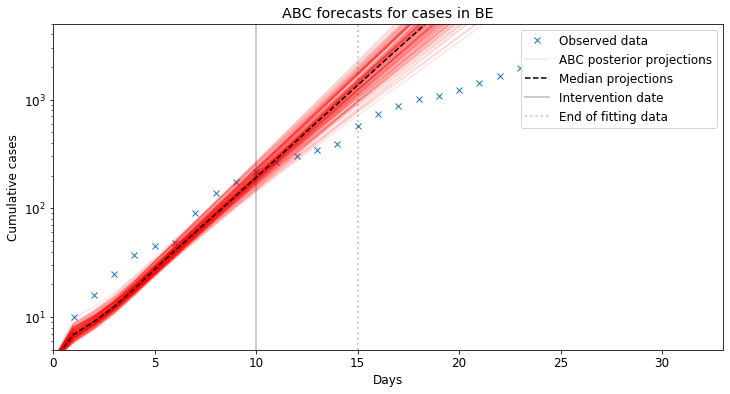

In [252]:
# Plot the simulated data - check it's sensible
#df = pd.read_csv('simulated_data/simulated_{}_{}_{}.csv'.format(metric,country, reg))
start_date = 0
t = np.linspace(0, len(reg_data)-1, len(reg_data))
fig = plt.figure()
plt.plot(reg_data[metric][start_date:], 'x', label = 'Observed data')

for i,x in enumerate(range(num_sims)):
    if i==0:
        plt.plot(pred[x], 'r', alpha=0.1,label='ABC posterior projections')
    else:
        plt.plot(pred[x], 'r', alpha=0.1)
plt.plot(np.median(pred, axis=0), 'k--', label = 'Median projections')
plt.title('ABC forecasts for {} in {}'.format(metric, reg))
plt.ylabel('Cumulative {}'.format(metric))
plt.xlabel('Days')
plt.axvline(x=int_date, linewidth=2, color='k', alpha=0.2, label='Intervention date')
plt.axvline(x=int_date+5, linewidth=2, color='k', ls=':', alpha=0.2, label='End of fitting data')
plt.legend()
plt.yscale('log')
plt.xlim(0, 33)
plt.ylim(5,5000)

#plt.savefig('simulated {} for {}.png'.format(fit_to, reg))
import pickle
with open('plots/DE_{}_{}_ABC.pickle'.format(reg, metric), 'wb') as f: # should be 'wb' rather than 'w'
    pickle.dump(fig, f)

In [207]:
# Do some cleaning up of the dataframe to get rid of unnecessary bits
fit_data = [int(x) for x in reg_data[metric]]
fit_dict = {metric:fit_data}
fit_df = pd.DataFrame.from_dict(fit_dict)
fit_df.to_csv('GP_input_data/{}_{}_{}_data.csv'.format(country, reg, metric))

In [208]:
## Check that num observations and num simulated data points are the same!
assert len(pred[0])==len(reg_data[metric][start_date:])

In [209]:
reg_data

,date,region,cases,new_cases,Unnamed: 4
0,0,NI,16,NaN,NaN
1,1,NI,16,NaN,NaN
2,2,NI,17,NaN,NaN
3,3,NI,19,NaN,NaN
4,4,NI,36,12.0,NaN
5,5,NI,49,16.0,Banned gatherings of 1000+ people
6,6,NI,75,26.0,NaN
7,7,NI,129,54.0,NaN
8,8,NI,230,101.0,NaN
9,9,NI,253,23.0,Effective school closures
